## Dataset encoding and model selection

Main tasks are:  
- create custom data preprocessing classes which can be used in pipelines
- get hands-on experience in constructing pipelines to prepare data for training and evaluating models
- test different preprocessing pipelines (WoE, simply encoded, mixed, etc.) and choose the best preprocessing strategy
- evaluate metrics values to compare model types

In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

import sklearn as skl
print('Scikit-learn version:', skl.__version__)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.dummy import DummyClassifier

from tqdm import tqdm

from copy import deepcopy

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
Scikit-learn version: 1.1.3


In [2]:
from preprocess_classes import (
    DFDropColumns, DFWoeEncoder, DFColumnBinning, DFValuesMapper, DFFuncApplyCols,
    DFCrossFeaturesImputer, DFOneHotEncoder, DFOrdinalEncoder, DFValuesReplacer
)

In [3]:
results_filename = 'datasets/processed/results.csv'

## Utility functions definition

In [4]:
# calculating real missing data ratio considering missing-like values (nan-equivalents)
def print_real_nans_ratio(df, cat_nan_equiv='unknown', num_nan_equiv=999):
    print(f'Calculating real NaNs ratio using `{str(cat_nan_equiv)}` and `{str(num_nan_equiv)}` keyvalues:')
    print('Column (value) \tNvalues \tRatio')
    print('-'*40)
    for col in df.columns:
        if df[col].dtype == 'object':
            nan_equiv = cat_nan_equiv
        else:
            nan_equiv = num_nan_equiv
        if nan_equiv in list(df[col]):
            freq_table = df[col].value_counts()
            print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

In [5]:
def preprocess_data(df=None, filename=None, y=None, target='y', pipeline=None, fit=False):
    """
    1. Loads data from file (if DataFrame is not loaded earlier)
    2. Splits DataFrame to target and predictors (if y not passed directly)
    3. Preprocess data using pipeline with ability to toggle fit stage
    """
    if df is None:
        if filename is None:
            raise ValueError('No filename passed')
        df_mod = pd.read_csv(filename)
    else:
        df_mod = df.copy()
    if (y is None) and (target in df_mod.columns):
        y_mod = pd.to_numeric(df_mod[target].map({'yes': 1, 'no': 0}))
        df_mod = df_mod.drop(columns=target)
    else:
        y_mod = y.copy()
    if pipeline is not None:
        if fit:
            df_mod = pipeline.fit_transform(df_mod, y_mod)
        else:
            df_mod = pipeline.transform(df_mod)
    return (df_mod, y_mod)

## Loading train and test data

In [6]:
import_filename = 'datasets/bank-train.csv'
df = pd.read_csv(import_filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

In [7]:
df.head(8)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes
5,52,technician,married,basic.6y,unknown,no,no,cellular,may,thu,...,3,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
6,29,technician,single,university.degree,no,yes,no,cellular,jun,wed,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,no
7,42,technician,married,professional.course,unknown,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no


In [8]:
# missing-like values
cat_nan_equiv = 'unknown'
num_nan_equiv = 999

In [9]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


In [10]:
df_test = pd.read_csv('datasets/bank-test.csv')

In [11]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


## Construct preprocessing pipelines

In [12]:
# definition of inputs for binning and encoding
age_bins = pd.IntervalIndex.from_breaks(np.arange(15, 110, 10))
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
default_map = {'yes': 1, 'no': 0, 'unknown': 0}
housing_map = {'yes': 1, 'no': 0, 'unknown': 1}
loan_map = {'yes': 1, 'no': 0, 'unknown': 0}
contact_map = {'cellular': 1, 'telephone': 0}
month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
poutcome_map = {'nonexistent': 0, 'success': 1, 'failure': -1}

# cutoff functions
cutoff_campaign = (lambda x: np.min([x, 6])) # value 6 was calculated in 2_eda for `campaign` feature as cutoff value
cutoff_previous = (lambda x: np.min([x, 3])) # value 3 was calculated in 2_eda for `previous` feature as cutoff value
cutoff_pdays = (lambda x: np.min([13, x])) # value 13 was calculated in 2_eda for `pdays` feature as cutoff value
binarize_pdays = (lambda x: int(x < 999)) # transforming to answer on question: was there a previous contact?

In [13]:
# using simple encoding + partial WoE
preproc_enc_woe_part = [
    'encoding, WOE partial, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(map_values={'contact': contact_map})),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome', #'pdays_bins'
            ], encode_nans=True, nan_equiv=cat_nan_equiv
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous,
            'pdays': cutoff_pdays,
        })),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), # try to drop columns with high correlation (`nr.employed` and `emp.var.rate`)
    ])
]

## Preprocessing and saving training and testing sets in separate files

In [14]:
X_train, y_train = preprocess_data(df=df, pipeline=preproc_enc_woe_part[1], fit=True)
# if any column has 'object'/'category' dtype while containing numerical values
# then change dtype for that column as it was preprocessed into numeric already
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train[col] = pd.to_numeric(X_train[col])
print('Train set processed')

X_test, y_test = preprocess_data(df=df_test, pipeline=preproc_enc_woe_part[1], fit=False)
print('Test set processed')

comment_line = f'# Preprocessing description: {preproc_enc_woe_part[0]}\n'

f = open('datasets/processed/bank-train-encoded2.csv', 'a')
f.write(comment_line)
pd.concat([X_train, y_train], axis=1).to_csv(f, index=False)
f.close()
print('Train set saved to file')

f = open('datasets/processed/bank-test-encoded2.csv', 'a')
f.write(comment_line)
pd.concat([X_test, y_test], axis=1).to_csv(f, index=False)
f.close()
print('Test set saved to file')

Train set processed
Test set processed
Train set saved to file
Test set saved to file


In [15]:
classifiers = [
    ('logistic_regression', Pipeline([
            ('scale', MinMaxScaler()),
            ('clf', LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=1000)),
        ])
    ),
    ('sgd', Pipeline([
            ('scale', MinMaxScaler()),
            ('clf', SGDClassifier(class_weight='balanced', random_state=42, loss='hinge')), # added after evaluation #loss='log_loss'
        ])
    ),
    ('random_forest', RandomForestClassifier(n_estimators=100, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    # ('svm', Pipeline([
    #         ('scale', MinMaxScaler()),
    #         ('clf', SVC())
    #     ])
    # ),
]
grid_params = {
    'logistic_regression': {'clf__C': np.logspace(-3, 2, 6)},
    'random_forest': {'max_depth': [x for x in range(2, 7, 2)]},
    'knn': {'n_neighbors': [x for x in range(2, 6)]},
    'sgd': {'clf__loss': ['hinge', 'log_loss']},
    #'svm': {'clf__kernel': ['rbf'], 'clf__C': np.logspace(-4, 2, 3), 'clf__gamma': np.logspace(-2, 2, 3)}
}

In [33]:
def get_model_results(model, train_set, test_set=None, show_charts=False, title=None):
    """
    Performs evaluation of the classifier model passed
    [Optionally] Builds visualizations (confusion matrix, curves)
    """
    metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 'auc': roc_auc_score}
    if show_charts:
        if test_set is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[2])
        else:
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
            conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
            roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
            pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
        if title is not None:
            fig.suptitle(title)
        fig.tight_layout()
    results = {}
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('-'*30)
    for m_name, m_func in metrics.items():
        results[m_name] = {} 
        results[m_name]['train'] = m_func(train_set[1], model.predict(train_set[0]))
        if test_set is not None:
            results[m_name]['test'] = m_func(test_set[1], model.predict(test_set[0]))
        print('{}:     \t{:.4f} \t{:.4f}'.format(m_name, results[m_name]['train'], 0.0 if test_set is None else results[m_name]['test']))
    
    return results

I'm going to assign recall as main metric because in this project cost of False Negative (missed profit) is much higher than False Positive (direct cost of call)

In [22]:
# recalculating of this cell is highly time consuming if svm is included in classifiers list so I make a possibility to load results from file
recalculate = True

if recalculate:
    records = []
    trained_classifiers = {}
    rec_n = -1

    for clf in classifiers:
        print('='*30)
        print('Evaluating with ', clf[0])
        print('='*30)
        clf_grid = GridSearchCV(estimator=clf[1], param_grid=grid_params[clf[0]], scoring='recall', cv=5, return_train_score=True)
        clf_grid.fit(X_train, y_train)
        results = get_model_results(clf_grid.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test], show_charts=False)
        trained_classifiers[clf[0]] = deepcopy(clf_grid.best_estimator_)
        for m_name, m_dict in results.items():
            for m_type, val in m_dict.items():
                #rec_n += 1
                records.append(
                    {
                        'clf_type': clf[0],
                        'metric_name': m_name,
                        'metric_type': m_type,
                        'metric_val': val
                    }
                )
    df_eval = pd.DataFrame(records)
    df_eval.to_csv('datasets/processed/evaluation_results.csv', index=False)
else:
    df_eval = pd.read_csv('datasets/processed/evaluation_results.csv')

Evaluating with  logistic_regression
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.7241 	0.7307
precision:     	0.2456 	0.2563
recall:     	0.6995 	0.7313
f1:     	0.3636 	0.3796
auc:     	0.7134 	0.7310
Evaluating with  sgd
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.7973 	0.8037
precision:     	0.3096 	0.3238
recall:     	0.6499 	0.6825
f1:     	0.4194 	0.4392
auc:     	0.7330 	0.7508
Evaluating with  random_forest
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.8034 	0.8075
precision:     	0.3161 	0.3268
recall:     	0.6404 	0.6688
f1:     	0.4232 	0.4390
auc:     	0.7322 	0.7470
Evaluating with  knn
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.9953 	0.8505
precision:     	0.9805 	0.3394
recall:     	0.9778 	0.3455
f1:     	0.9792 	0.3425
auc:     	0.9877 	0.6301


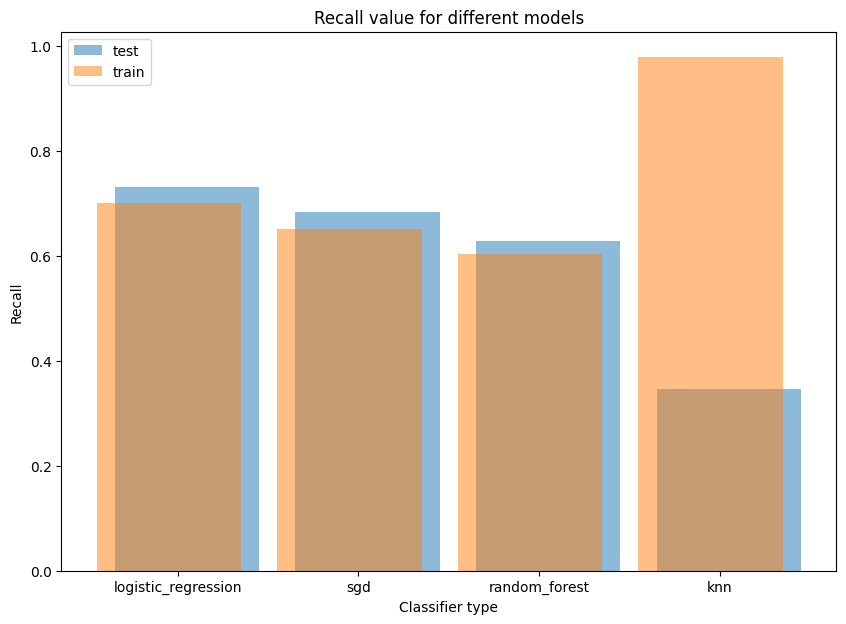

In [18]:
tmp = df_eval[df_eval['metric_name']=='recall']
x_labels = tmp.loc[df_eval['metric_type']=='train', 'clf_type']
x_ticks = range(len(x_labels))
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.bar(x=[x+0.05 for x in range(len(x_labels))] , height=tmp.loc[df_eval['metric_type']=='test', 'metric_val'], alpha=.5, label='test')
ax.bar(x=[x-0.05 for x in range(len(x_labels))], height=tmp.loc[df_eval['metric_type']=='train', 'metric_val'], alpha=.5, label='train')
#sns.stripplot(data=df_eval[df_eval['metric_name']=='recall'], x='clf_type', y='metric_val', hue='metric_type', ax=ax)
ax.set_xlabel('Classifier type')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylabel('Recall')
ax.set_title('Recall value for different models')
ax.legend();

In [29]:
vote_clf = VotingClassifier(
    estimators=trained_classifiers.items(),
    #voting='soft',
    weights=np.array([0.32, 0.32, 0.32, 0.04])
)
vote_clf.fit(X_train, y_train)
print(f'Training recall: {recall_score(y_train, vote_clf.predict(X_train)):.3f}')
print(f'Testing recall: {recall_score(y_test, vote_clf.predict(X_test)):.3f}')

Training recall: 0.664
Testing recall: 0.694


Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.7241 	0.7307
precision:     	0.2456 	0.2563
recall:     	0.6995 	0.7313
f1:     	0.3636 	0.3796
auc:     	0.7134 	0.7310
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.7973 	0.8037
precision:     	0.3096 	0.3238
recall:     	0.6499 	0.6825
f1:     	0.4194 	0.4392
auc:     	0.7330 	0.7508
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.8034 	0.8075
precision:     	0.3161 	0.3268
recall:     	0.6404 	0.6688
f1:     	0.4232 	0.4390
auc:     	0.7322 	0.7470
Scores:
Indicator  	Train 	Test
------------------------------
accuracy:     	0.9953 	0.8505
precision:     	0.9805 	0.3394
recall:     	0.9778 	0.3455
f1:     	0.9792 	0.3425
auc:     	0.9877 	0.6301


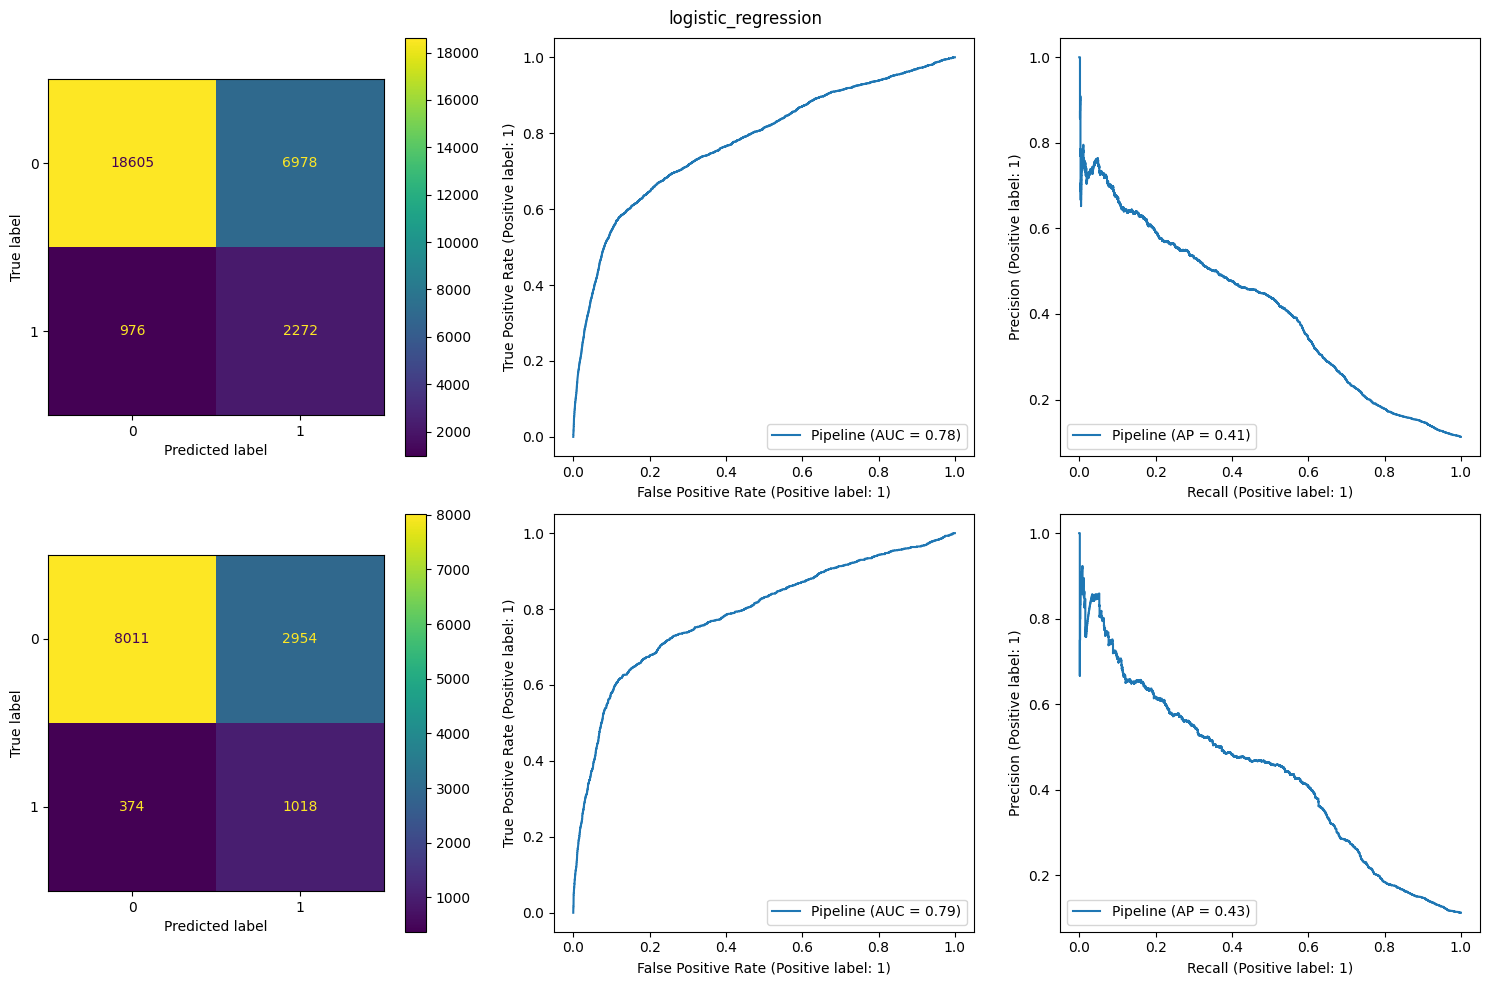

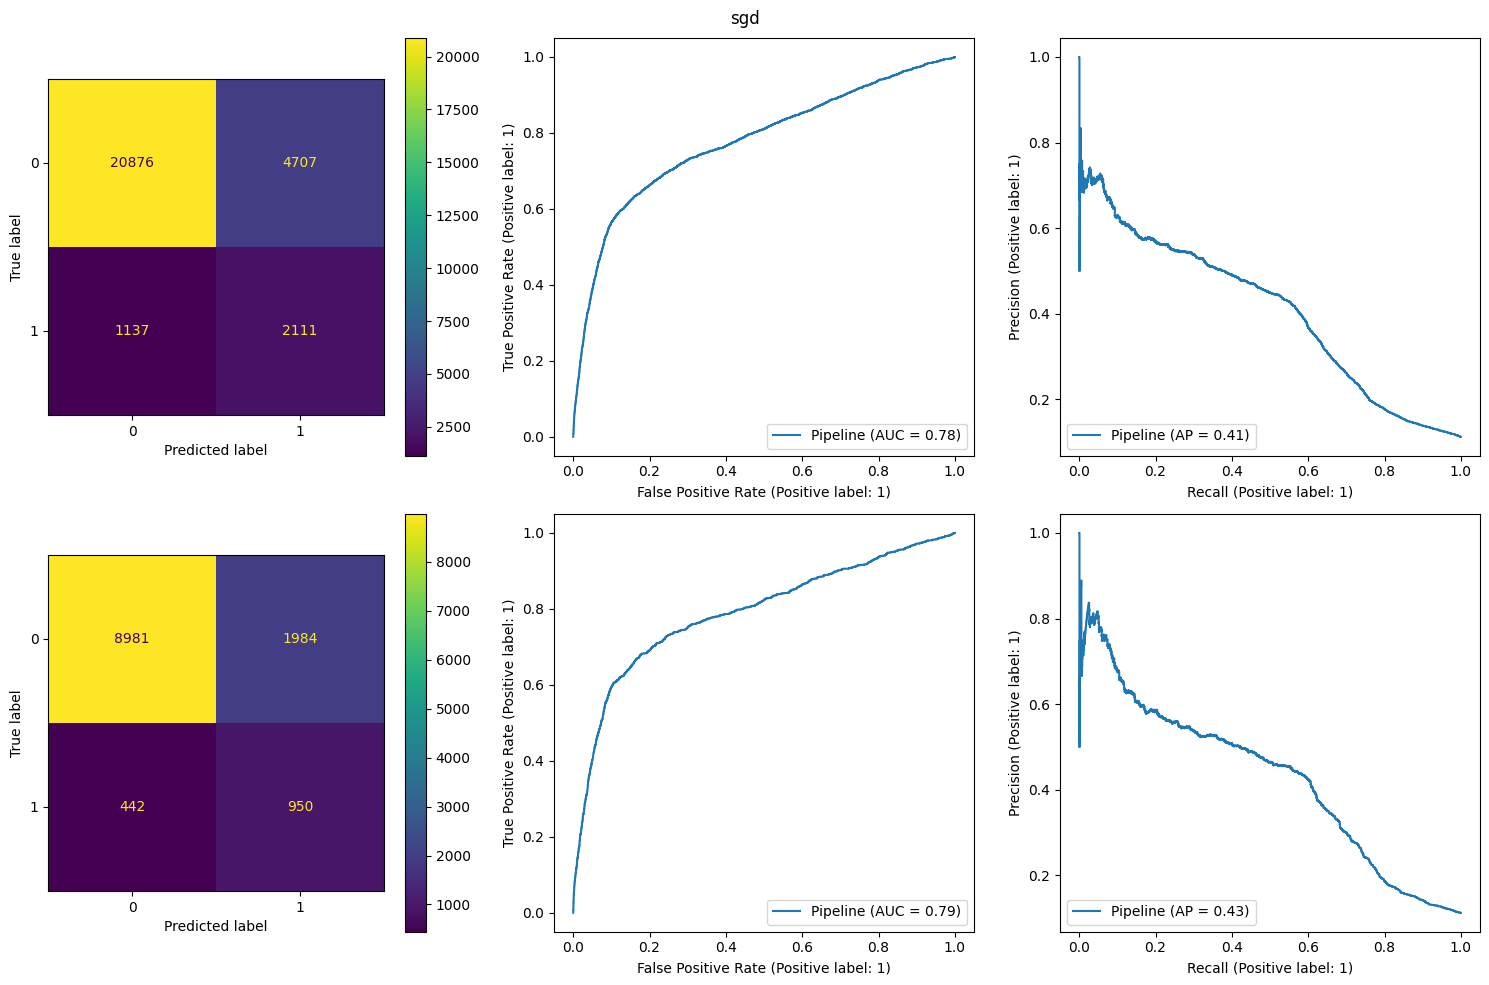

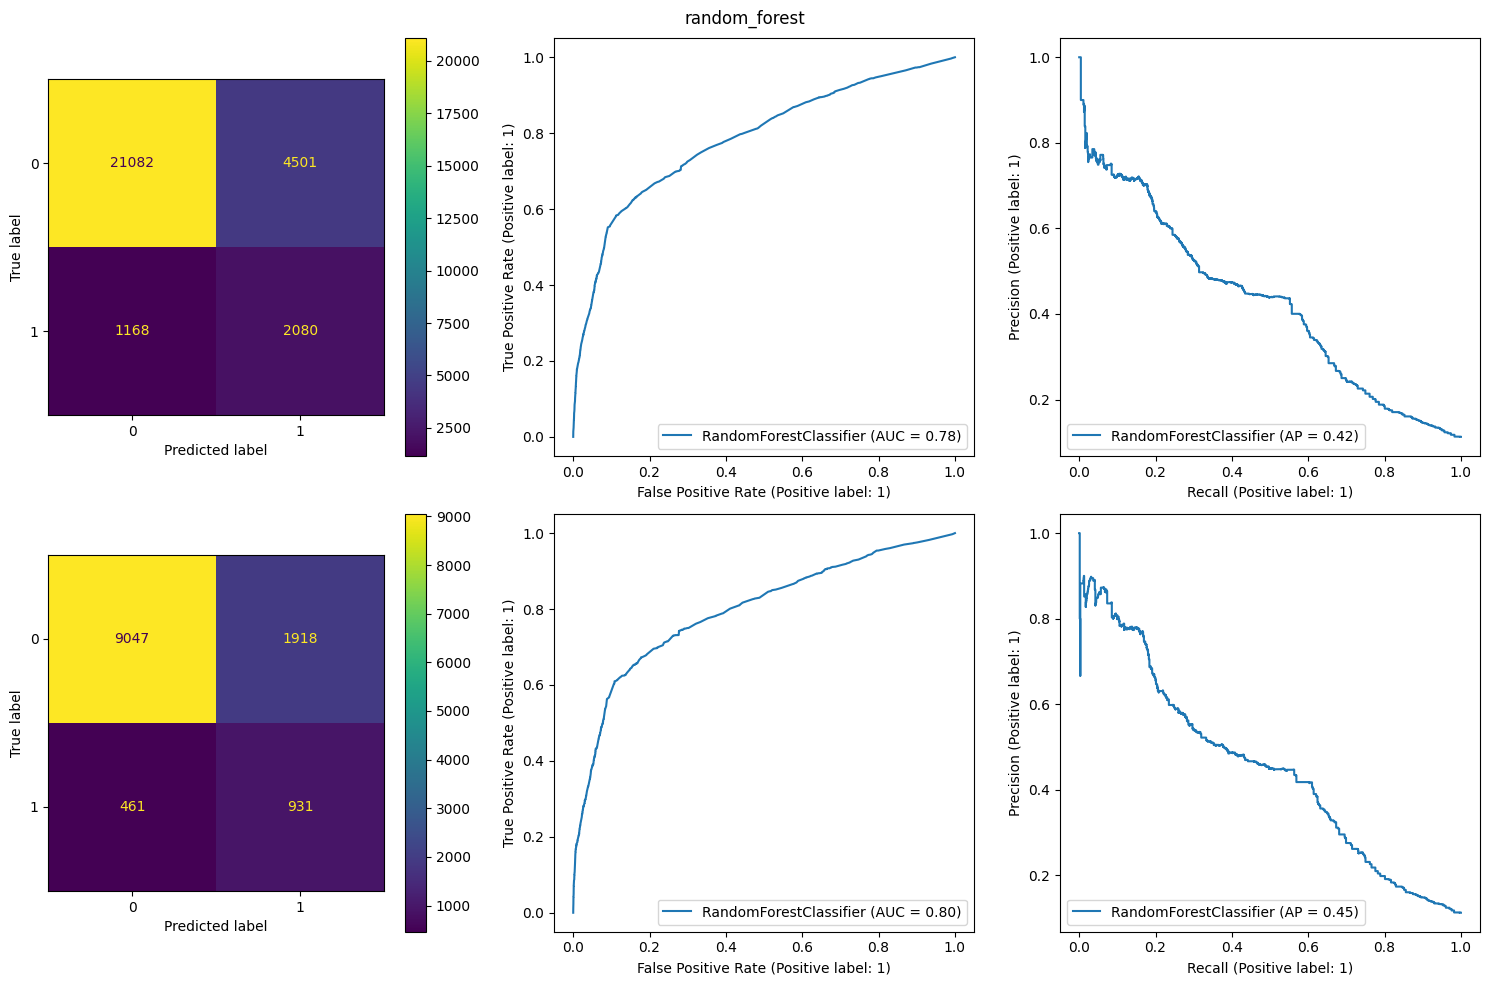

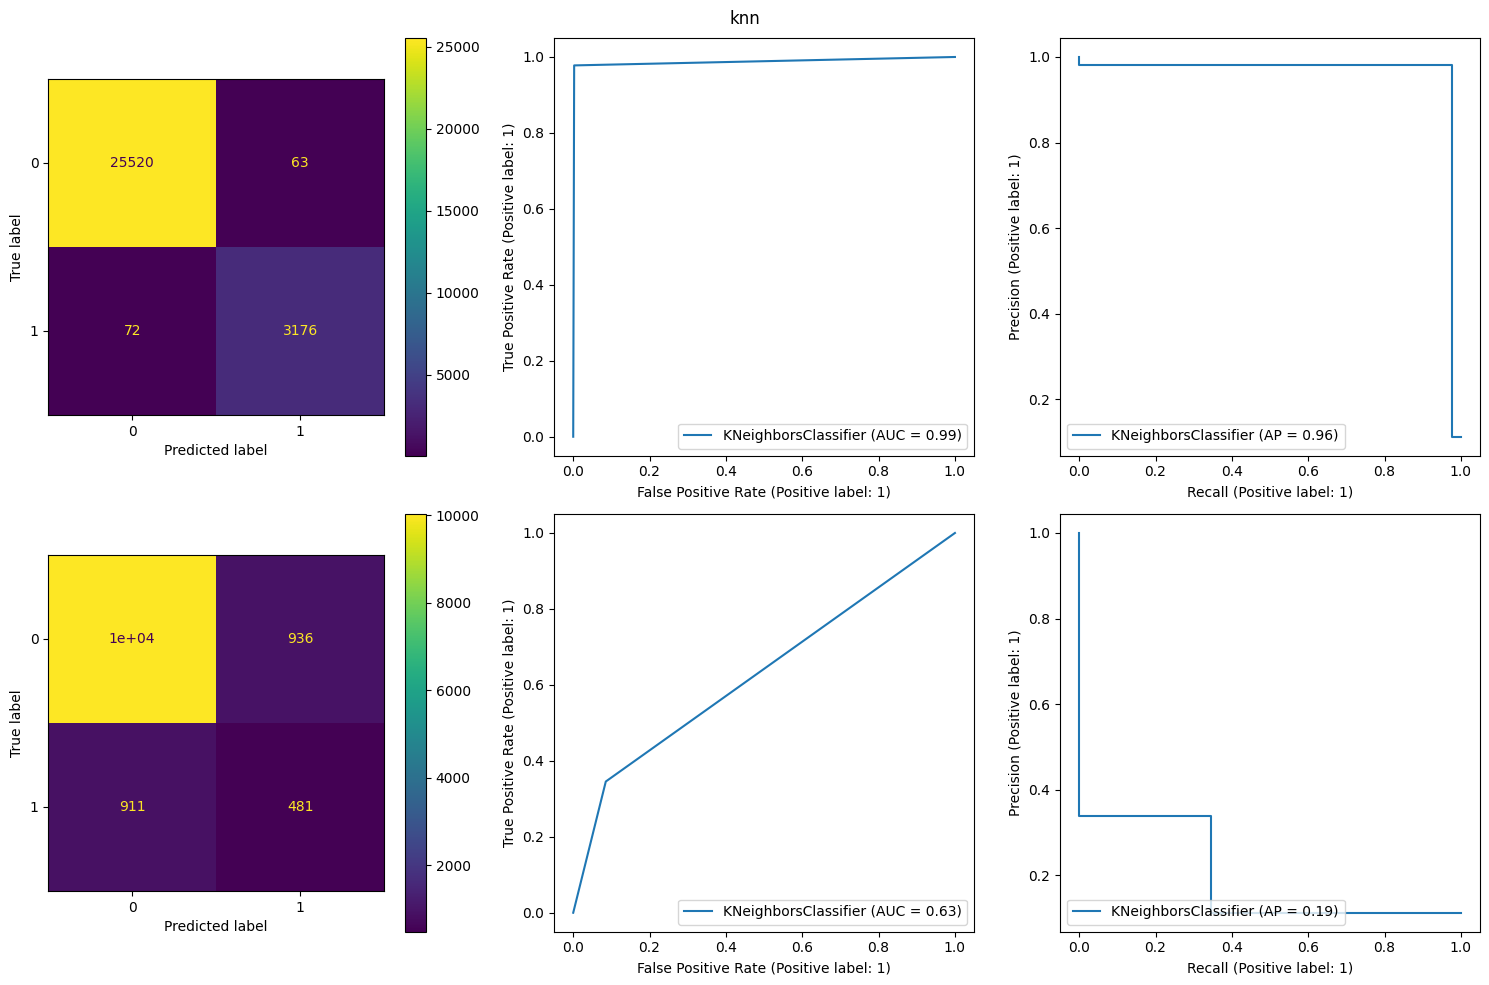

In [34]:
for name, clf in trained_classifiers.items():
    res = get_model_results(clf, train_set=[X_train, y_train], test_set=[X_test, y_test], show_charts=True, title=name)